## installs and imports

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# cd into the repository 
%cd /content/drive/MyDrive/github/enterpret/ 

/content/drive/MyDrive/github/enterpret


In [7]:
!pwd

/content/drive/MyDrive/github/enterpret


In [ ]:
# install requirements
!pip install transformers sentence-transformers datasets sentencepiece wandb

In [8]:
# import libraries
import csv
import gzip
import os
import pandas as pd
import numpy as np
from tqdm import tqdm 

import wandb
import torch
from datasets import load_dataset
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score

import sentencepiece
from sentence_transformers.cross_encoder.evaluation import CEBinaryClassificationEvaluator
from sentence_transformers import SentenceTransformer, CrossEncoder, util, losses, InputExample, models
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator, BinaryClassificationEvaluator
from transformers import DataCollatorWithPadding, AutoTokenizer, AutoModelForSequenceClassification, AutoConfig
from transformers.integrations import WandbCallback

import json
import matplotlib.pyplot as plt

In [9]:
# wandb login
# os.environ['WANDB_API_KEY'] = '46c39bbac8b187eeb815386597ca25ba414d4c5e'
# os.environ['WANDB_PROJECT'] = 'enterpret'
# wandb.login()

In [10]:
# import gc
# torch.cuda.empty_cache()
# gc.collect()

## utilss

In [22]:
# utils

def get_test_data_for_evaluator(raw_datasets=None, split='test'):
    # getting evaluator on our own data ()
    n_inputs = len(raw_datasets[split]["text"])
    test_inputs = []
    debug_test_inputs = []

    for i in tqdm(range(n_inputs)):
      score = float(raw_datasets[split]['label'][i])
      test_inputs.append(InputExample(texts=[raw_datasets[split]['text'][i], raw_datasets[split]["reason"][i]], label=score))
      if i<3:
        debug_test_inputs.append([raw_datasets[split]['text'][i], raw_datasets[split]["reason"][i],score])

    return test_inputs


def compute_metrics(predictions, labels)-> dict:
    accuracy = accuracy_score(labels, predictions)
    precision = precision_score(labels, predictions, zero_division=0)
    recall = recall_score(labels, predictions, zero_division=0)
    f1 = f1_score(labels, predictions, zero_division=0)
    # ap_score = average_precision_score(labels, predictions, zero_division=0)
    # auc_roc = roc_auc_score(labels, predictions)
    result = {"accuracy": accuracy, "precision":precision, "recall":recall, "f1":f1}
    return result


def predict_labels(outputs, labels, threshold):
    predicted_labels = [1.0 if o >= threshold else 0.0 for o in outputs]
    return predicted_labels

def calculate_metrics(outputs, labels, threshold_values, cos_sim=None):
    all_results = {'accuracy':[], 'f1':[], 'precision':[], 'recall':[]}
    for threshold in threshold_values:
        predicted_labels = predict_labels(outputs, labels, threshold)
        # print(outputs[:10], labels[:10])
        results = compute_metrics(predicted_labels, labels)
        all_results["accuracy"].append(results["accuracy"])
        all_results["recall"].append(results["recall"])
        all_results["precision"].append(results["precision"])
        all_results["f1"].append(results['f1'])
    
    # all_results["average_precision_score"].average_precision_score(labels, outputs, zero_division=0)
#     return accuracy_scores, recall_scores
    return all_results


## get raw 



In [13]:
# get our custom data

train_file = "./data/train.csv"
test_file = "./data/test.csv"
data_files = {}
data_files["train"] = train_file
data_files["test"] = test_file

raw_datasets = load_dataset('csv', data_files=data_files)

  0%|          | 0/2 [00:00<?, ?it/s]

## finetune sentense transformers

In [14]:
# load the model

# model_id = "sentence-transformers/all-MiniLM-L6-v2"
# model = SentenceTransformer(model_id)
# device = "cuda:0" if torch.cuda.is_available() else "cpu"
# model.to(device)


In [16]:
# dir(models.Transformer))

# model.to(device)

In [26]:
model_name = 'bert-base-uncased'
word_embedding_model = models.Transformer(model_name)
pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension(),
                               pooling_mode_mean_tokens=True,
                               pooling_mode_cls_token=False,
                               pooling_mode_max_tokens=False)
model = SentenceTransformer(modules=[word_embedding_model, pooling_model])
device = "cuda:0" if torch.cuda.is_available() else "cpu"
model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


SentenceTransformer(
  (0): Transformer({'max_seq_length': 512, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
)

In [18]:
# help(smodel.fit)
def callback(score, epoch, steps):
    print(score, epoch, steps)


In [19]:
# get test data
test_inputs = get_test_data_for_evaluator(raw_datasets, split='test')

100%|██████████| 9000/9000 [02:50<00:00, 52.65it/s]


In [ ]:
# get train data
train_inputs = []
debug_inputs = []
n_inputs = len(raw_datasets["train"]["text"])

for i in tqdm(range(n_inputs)):
  score = float(raw_datasets['train']['label'][i])
  train_inputs.append(InputExample(texts=[raw_datasets["train"]['text'][i], raw_datasets["train"]["reason"][i]], label=score))
  # debug_inputs.append([raw_datasets["train"]['text'][i], raw_datasets["train"]["reason"][i]])
  train_inputs.append(InputExample(texts=[raw_datasets["train"]['reason'][i], raw_datasets["train"]["text"][i]]))

 46%|████▌     | 940/2061 [00:15<00:16, 67.56it/s]

In [ ]:
# # get the dataloaders. training and an evaluator(validation/testing)

batch_size=32
train_dataloader = DataLoader(train_inputs, shuffle=True, batch_size=batch_size, collate_fn=model.smart_batching_collate)

test_evaluator = EmbeddingSimilarityEvaluator.from_input_examples(test_inputs, batch_size=batch_size, name=f"finetuning-{model_name}", show_progress_bar=True)

# # we use sts-benchmark data for evaluator
# sts_dataset_path='data/stsbenchmark.tsv.gz'
# if not os.path.exists(sts_dataset_path):
#     util.http_get('https://sbert.net/datasets/stsbenchmark.tsv.gz', sts_dataset_path)
# dev_samples = []
# with gzip.open(sts_dataset_path, 'rt', encoding='utf8') as fIn:
#  output   reader = csv.DictReader(fIn, delimiter='\t', quoting=csv.QUOTE_NONE)
#     for row in reader:
#         if row['split'] == 'dev':
#             score = float(row['score']) / 5.0 #Normalize score to range 0 ... 1
#             dev_samples.append(InputExample(texts=[row['sentence1'], row['sentence2']], label=score))

# dev_evaluator = EmbeddingSimilarityEvaluator.from_input_examples(dev_samples, batch_size=batch_size, name='sts-dev', write_csv=True)

In [ ]:
# define training arguments and train!
output_path = f"./output/{model_name}-MNRloss_both_inputs"
num_epochs = 5
warmup_steps = int(len(train_dataloader) * num_epochs * 0.1)
train_loss = losses.MultipleNegativesRankingLoss(model)
model.fit(train_objectives=[(train_dataloader, train_loss)],
           epochs=num_epochs,  
           evaluator=test_evaluator,
           scheduler='constantlr',
           evaluation_steps=int(len(train_dataloader)),
           warmup_steps=warmup_steps,
           save_best_model=True, 
           callback=callback,
           show_progress_bar=True,
           output_path=output_path)

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Batches:   0%|          | 0/282 [00:00<?, ?it/s]

Batches:   0%|          | 0/282 [00:00<?, ?it/s]

0.4653607503362344 0 129


Batches:   0%|          | 0/282 [00:00<?, ?it/s]

Batches:   0%|          | 0/282 [00:00<?, ?it/s]

0.4653607503362344 0 -1


Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Batches:   0%|          | 0/282 [00:00<?, ?it/s]

Batches:   0%|          | 0/282 [00:00<?, ?it/s]

0.43562125089029785 1 129


Batches:   0%|          | 0/282 [00:00<?, ?it/s]

Batches:   0%|          | 0/282 [00:00<?, ?it/s]

0.43562125089029785 1 -1


Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Batches:   0%|          | 0/282 [00:00<?, ?it/s]

Batches:   0%|          | 0/282 [00:00<?, ?it/s]

0.42670498905360915 2 129


Batches:   0%|          | 0/282 [00:00<?, ?it/s]

Batches:   0%|          | 0/282 [00:00<?, ?it/s]

0.42670498905360915 2 -1


Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Batches:   0%|          | 0/282 [00:00<?, ?it/s]

Batches:   0%|          | 0/282 [00:00<?, ?it/s]

0.4353283798155188 3 129


Batches:   0%|          | 0/282 [00:00<?, ?it/s]

Batches:   0%|          | 0/282 [00:00<?, ?it/s]

0.4353283798155188 3 -1


Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Batches:   0%|          | 0/282 [00:00<?, ?it/s]

Batches:   0%|          | 0/282 [00:00<?, ?it/s]

0.44308844271211417 4 129


Batches:   0%|          | 0/282 [00:00<?, ?it/s]

Batches:   0%|          | 0/282 [00:00<?, ?it/s]

0.44308844271211417 4 -1


In [63]:
# for model_id in models:
# device = "cuda:0" if torch.cuda.is_available() else "cpu"
# from sentence_transformers import SentenceTransformer, util
# sentences = ["I'm happy", "I'm full of happiness"]

#Compute embedding for both lists
outputs = []
model = SentenceTransformer(output_path)
# print(model)
# model.to(device)
# model = smodel

split='test'
for i in tqdm(range(len(raw_datasets[split]))):
    embedding_1 = model.encode(raw_datasets[split]['text'][i], convert_to_tensor=True)
    embedding_2 = model.encode(raw_datasets[split]['reason'][i], convert_to_tensor=True)

    sim = util.pytorch_cos_sim(embedding_1, embedding_2)    
    # print(sim)
    outputs.append(sim.item())
    
print(outputs)

threshold_values = [i/100 for i in range(101)]
all_results = calculate_metrics(outputs, raw_datasets[split]['label'] , threshold_values)

100%|██████████| 9000/9000 [06:11<00:00, 24.22it/s]


[0.6553459167480469, 0.5892924070358276, 0.4405730962753296, 0.6669776439666748, 0.2472686469554901, 0.6179463267326355, 0.4048915207386017, 0.5941575765609741, 0.16327200829982758, 0.3671003580093384, 0.19836121797561646, 0.18830351531505585, 0.7568648457527161, 0.6591074466705322, 0.3531550168991089, 0.23891493678092957, 0.6675561666488647, 0.44463324546813965, 0.6934830546379089, 0.5447977185249329, 0.4525581896305084, 0.169131338596344, 0.47943490743637085, 0.36627987027168274, 0.0375690832734108, 0.8642320036888123, 0.8170140385627747, 0.39403480291366577, 0.6288356184959412, 0.27489396929740906, 0.30499982833862305, 0.5858057141304016, 0.19744637608528137, 0.25045645236968994, 0.7587478160858154, 0.2628592252731323, 0.43412262201309204, 0.5931690335273743, 0.5221104621887207, 0.363150954246521, 0.5717648267745972, 0.06210608407855034, 0.3587133586406708, 0.6903561949729919, 0.7243181467056274, 0.9104286432266235, 0.318598210811615, 0.5987882018089294, 0.5478165745735168, 0.638271

In [65]:
# all_results['accuracy'][59]
# plt.plot(threshold_values,all_results['accuracy'], label='accuracy')
# plt.xlabel('Threshold')
# plt.ylabel(f'accuracy')
# plt.legend()
# outputs
all_results["average_precision_score"] = average_precision_score(raw_datasets["test"]['label'], outputs)
all_results["average_precision_score"]

0.6421520497909171

Best Threshold is 0.59 and best reults are - 
 {'accuracy': 0.7398888888888889, 'f1': 0.5545195052331113, 'precision': 0.6464063886424135, 'recall': 0.4855048317227591}


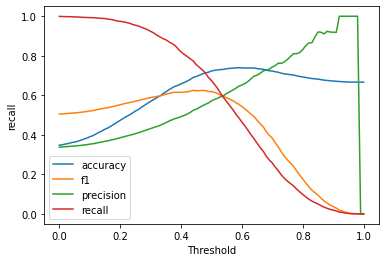

In [64]:
for k,v in all_results.items():
  # print(k,v)
  if k=="average_precision_score":break
  plt.plot(threshold_values, v, label=k)
  plt.xlabel('Threshold')
  plt.ylabel(f'{k}')
  plt.legend()
  # plt.legend(k)
  # plt.show()
  # plt.savefig(f"./figs/{model_id.replace('/','-')}_metrics-vs-threshold")

best_metrics_idx = np.argmax(all_results['accuracy']) 
best_metrics = {}
for metric in all_results:
    if metric=="average_precision_score":break
    best_metrics[metric] = all_results[metric][best_metrics_idx] 
print(f"Best Threshold is {threshold_values[best_metrics_idx]} and best reults are - \n {best_metrics}")

In [47]:
from sklearn.metrics import confusion_matrix

def calculate_confusion_metrics(predictions, labels):
    tn, fp, fn, tp = confusion_matrix(labels, predictions).ravel()
    return tp, fp, tn, fn

def map_prob_to_label(probs, threshold=0.5):
    labels = [1 if prob >= threshold else 0 for prob in probs]
    return labels

predictions = map_prob_to_label(outputs)

tp, fp, tn, fn = calculate_confusion_metrics(predictions, raw_datasets['test']['label'])
print(f"tp {tp}, fp {fp}, tn {tn}, fn {fn}")

tp 2153, fp 1712, tn 4287, fn 848


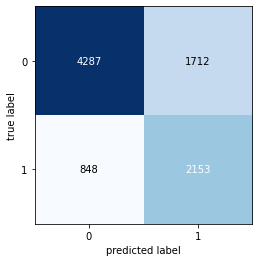

In [66]:
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

binary1 = np.array([[tn, fp],
                    [fn, tp]])

fig, ax = plot_confusion_matrix(conf_mat=binary1)
plt.show()

Best Threshold is 0.74 and best reults are - 
 {'accuracy': 0.7036666666666667, 'f1': 0.3850587964030436, 'precision': 0.625, 'recall': 0.2782405864711763}


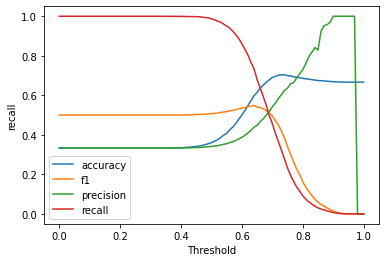

In [ ]:
for k,v in all_results.items():
  # print(k,v)
  plt.plot(threshold_values, v, label=k)
  plt.xlabel('Threshold')
  plt.ylabel(f'{k}')
  plt.legend()
  # plt.legend(k)
  # plt.show()
  # plt.savefig(f"./figs/{model_id.replace('/','-')}_metrics-vs-threshold")

best_metrics_idx = np.argmax(all_results['accuracy']) 
best_metrics = {}
for metric in all_results:
    best_metrics[metric] = all_results[metric][best_metrics_idx] 
print(f"Best Threshold is {threshold_values[best_metrics_idx]} and best reults are - \n {best_metrics}")

# finetune_results[model_id] = best_metrics

In [79]:
# before_train = all_results['accuracy']
# all_results['accuracy'][74]model
all_results

NameError: ignored

### ......

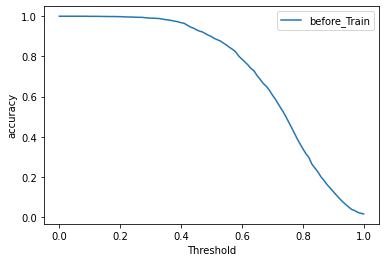

In [ ]:
plt.plot(threshold_values, before_train, label="before_Train")
plt.xlabel('Threshold')
plt.ylabel(f'accuracy')
plt.legend()

In [ ]:
test_inputs = get_test_data_for_evaluator(raw_datasets)

# test_evaluator = BinaryClassificationEvaluator.from_input_examples(test_inputs, batch_size=32, name='custom-data-test', show_progress_bar=True)
# test_evaluator(smodel, output_path="./output/test")


100%|██████████| 9000/9000 [05:51<00:00, 25.58it/s]


In [ ]:
def test(model=None, model_id=None, inputs=None, batch_size=32, output_path=None, name=None):
  """
  Input arguments: model=None, model_id=None, inputs=None, batch_size=32, output_path=None, name=None
  Function: send a model and inputs and get BinaryClassification metrics at specified output.
  Returns : average precision score for all thresholds (float)
  """

  if (output_path==None): ouput_path="./output/test/"

  if model_id==None and model==None:
    model_id="sentence-transformers/all-MiniLM-L6-v2"
  
  if model_id==None:
    print("No model_id but a model was passed, pass a model_id!!!!!")
    return 0

  name = f'{model_id.split("/")[1]}-test' if name is None else name

  if model_id.split('/')[0]=="sentence-transformers":
    test_evaluator = BinaryClassificationEvaluator.from_input_examples(inputs, batch_size=batch_size, name=name, show_progress_bar=True)
    model = SentenceTransformer(model_id) if model==None else model
  else :
    test_evaluator = CEBinaryClassificationEvaluator.from_input_examples(inputs, name=name, show_progress_bar=True)
    model = CrossEncoder(model_id) if model==None else model
  
  avgp = test_evaluator(model, output_path=output_path)
  return avgp

## testing pretrained models for baseline metrics

In [ ]:
# help(CrossEncoder)

test_evaluator = EmbeddingSimilarityEvaluator.from_input_examples(test_inputs, batch_size=32, name=f"{model_id.replace('/','-')}-before_training-results_on_train_data", show_progress_bar=True)
test_evaluator(model, output_path="./output/testing-results/")


Batches:   0%|          | 0/65 [00:00<?, ?it/s]

Batches:   0%|          | 0/65 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/usr/local/lib/python3.8/dist-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


nan

In [ ]:
## testing a nli pretrained model on custom data
# model_id = "cross-encoder/nli-deberta-v3-base"
# test(model_id)
# nli_model = CrossEncoder(model_id, num_labels=3)

# test_evaluator = CEBinaryClassificationEvaluator.from_input_examples(test_inputs, name='pretrained-CE-custom-data-test', show_progress_bar=True)
test_evaluator(model, output_path="./output/testing-results/")


NameError: ignored

In [ ]:
#

model_id = "sentence-transformers/all-MiniLM-L6-v2"
model_id = "cross-encoder/nli-deberta-v3-base"
test(model_id=model_id, inputs=test_inputs[:100], name=f"testing_pretrained_sentencetransformer_{model_id.split('/')[1]}")

# model = SentenceTransformer(model_id)
# test_evaluator = BinaryClassificationEvaluator.from_input_examples(test_inputs, batch_size=32, name=f'pretrained-{model_id.split("/")[1]}-custom-data-test', show_progress_bar=True)
# test_evaluator(model, output_path="./output/test")

'all-MiniLM-L6-v2'

## rough

In [ ]:
# def get_dataloaders(raw_datasets, tokenizer):

#     num_labels = 3
#     label_list = [0.0,1.0]
#     non_label_column_names = [name for name in raw_datasets["train"].column_names if name != "label"]
#     sentence1_key, sentence2_key = non_label_column_names[:2]
#     label_to_id = {v: i for i, v in enumerate(label_list)}
#     padding = "max_length"

#     def preprocess_function(examples):
#         texts = (examples[sentence1_key],examples[sentence2_key])
#         result = tokenizer(*texts, padding=padding, max_length=100, truncation=True, return_tensors="pt")
#         # if "label" in examples:
#         # if label_to_id is not None:
#         #     # Map labels to IDs (not necessary for GLUE tasks)
#         #     result["labels"] = [label_to_id[l] for l in examples["label"]]
#         # else:
#         #     # In all cases, rename the column to labels because the model will expect that.
#         #     result["labels"] = examples["label"]
        
#         return result

#     processed_datasets = raw_datasets.map(
#         preprocess_function,
#         batched=True,
#         remove_columns=raw_datasets["train"].column_names,
#         desc="Running tokenizer on dataset",
#     )


#     train_dataset = processed_datasets["train"]
#     # eval_dataset = processed_datasets["test"]
#     data_collator = DataCollatorWithPadding(tokenizer, pad_to_multiple_of=(8))
#     train_dataloader = DataLoader(train_dataset, collate_fn=data_collator, batch_size=16)
#     # eval_dataloader = DataLoader(eval_dataset, collate_fn=data_collator, batch_size=16)

#     return train_dataloader

In [ ]:
results={}


In [ ]:
# model_name = "sentence-transformers/all-mpnet-base-v2"
# config = AutoConfig.from_pretrained(model_name, num_labels=3)
# tokenizer = AutoTokenizer.from_pretrained(model_name)
# model = AutoModelForSequenceClassification.from_pretrained(model_name, config=config, ignore_mismatched_sizes=True)

# results[model_name] = {}

# train_dataloader = get_dataloaders(raw_datasets, tokenizer)

In [ ]:
# import random

3

In [ ]:
!python ./src/training.py 

Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
----------------------------------------------------------------------------------------------------
++++++++++++++++++++++++++++++++++
['A person on a horse jumps over a broken down airplane.', 'A person is outdoors, on a horse.', 'A person is at a diner, ordering an omelette.'] ['A person

## data EDA

In [15]:
labels,counts = np.unique(raw_datasets['test']['label'], return_counts=True)

In [18]:
len(raw_datasets['train']['label'])

2061

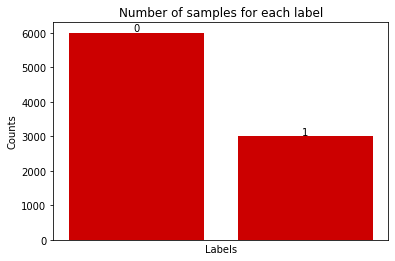

In [99]:
plt.bar(labels, counts, color="#cc0000")
plt.xlabel('Labels')
plt.ylabel('Counts')
plt.title('Number of samples for each label')
plt.xticks([])
for i, count in enumerate(counts):
    plt.text(labels[i], count + 35, str(int(labels[i])), ha='center')
plt.show()

In [95]:
split='test'

texts = raw_datasets[split]['text'] 
reasons = raw_datasets[split]['reason']
avg_word_lengths = []
avg_char_lengths = []

for _ in (texts,reasons):
    char_lengths = []
    word_lengths = []

    for text in _:
        chars, words = len(text), len(text.split())
        char_lengths.append(chars)
        word_lengths.append(words)

    print(len(char_lengths))
    print(np.mean(word_lengths))
    avg_char_lengths.append(np.mean(char_lengths))
    avg_word_lengths.append(np.mean(word_lengths))



9000
17.392
9000
4.957222222222223


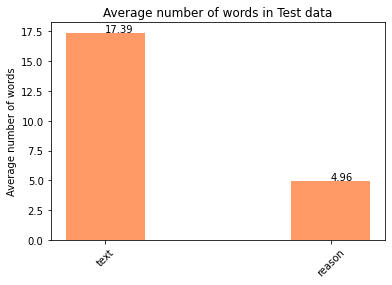

In [98]:
import matplotlib.pyplot as plt

def plot_bars(x, y, ylabel, title):
    fig, ax = plt.subplots()
    bar_width = 0.35
    bar = ax.bar(x, y, bar_width, color="#ff9966")
    # ax.set_xlabel('Categories')
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    for i, b in enumerate(bar):
        ax.text(b.get_x() + b.get_width()/2, b.get_height() + 0.05, str(round(y[i], 2)))
    plt.xticks(rotation=45)
    plt.show()

categories = ["text", "reason"]
# avg_word_lengths = [4.67, 5.0]

plot_bars(categories, avg_word_lengths, 'Average number of words', 'Average number of words in Test data')

## wandb log


In [ ]:
# !pip install wandb
import wandb
import os
os.environ['WANDB_API_KEY'] = '46c39bbac8b187eeb815386597ca25ba414d4c5e'
os.environ['WANDB_PROJECT'] = 'enterpret'
wandb.login()

True

In [ ]:
name=model_id
name
run = wandb.init(project="enterpret", name=name, job_type="testing", group="pretrained")

In [ ]:
# metrics = all_results.keys()
# # print(data, data[name])
# for metric in metrics:
#   print(metric, all_results[metric])
  # wandb.log(metric:)
# for metric in data[name]:
# # wandb.log(data[name])
#   print(metric)
print(best_metrics)

{'accuracy': 0.8283333333333334, 'f1': 0.7337584008271584, 'precision': 0.7598144182726624, 'recall': 0.7094301899366877}


In [ ]:
run.log(best_metrics)

In [ ]:
wandb.finish()

accuracy,▁
f1,▁
precision,▁
recall,▁
accuracy,0.82833
f1,0.73376
precision,0.75981
recall,0.70943


## github

In [15]:
!cp ./#gitignore.txt ./.gitignore

In [16]:
!git init

Reinitialized existing Git repository in /content/drive/MyDrive/github/enterpret/.git/


In [17]:

!git add .

In [26]:
!git config --global user.email "mindadeepam@gmail.com"
!git config --global user.name "mindadeepam"

!git commit -m "first commit"
# !git branch -M main


On branch main
Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git restore <file>..." to discard changes in working directory)
	modified:   enterpret-finetune-sentence-transformers.ipynb

no changes added to commit (use "git add" and/or "git commit -a")


In [27]:
!git remote add origin https://github.com/mindadeepam/enterpret-NLI.git

fatal: remote origin already exists.


In [29]:
!git push -u origin main

fatal: could not read Username for 'https://github.com': No such device or address
